In [27]:
#importando as bibliotecas
import pandas as pd
from pandas import DataFrame
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, linear_model
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline

In [19]:
#importando biblioteca do yahoo finaças
import pandas_datareader.data as web
import yfinance as yf
yf.pdr_override()

In [20]:
#acao = 'BRML3.SA' #BR Malls
acao = 'AMAR3.SA' #Marisa

In [21]:
#Obtendo cotações # os numeros devem ser strings - se quiser por data final , end = 'YYYY-MM-DD'
ibov = web.get_data_yahoo(acao, start='2020-11-15',end = '2021-11-19')

#salvar arquivo
round(ibov,2).to_csv('acoes.csv')

[*********************100%***********************]  1 of 1 completed


In [22]:
df = pd.read_csv('acoes.csv', index_col = 0)

In [28]:
#Criando uma função para fazer um loop e realizar a previsão dos valores de Máxima, Mínima e Fechamento diário.
def previsa(variavel):
    #criando novos campos de medias móveis
    df = pd.read_csv('acoes.csv', index_col = 0)
    df['mm4d'] = df[variavel].rolling(5).mean()
    #df['mm8d'] = df[variavel].rolling(8).mean()
    
    #separando dados de entrada e saída
    valor_novo = pd.DataFrame(df.iloc[len(df)-1])
    valor = valor_novo.drop(['Open','Adj Close', variavel], 0)
    
    #Empurrando para frente os valores das ações para prever o proximo dia
    df[variavel] = df[variavel].shift(-1)

    #retirando os dados nulos
    df.dropna(inplace=True)
    
    #definindo quantidade de linhas
    qtd_linhas = len(df)
    qtd_linhas_treino= round(.70 * qtd_linhas)
    qtd_linhas_teste= qtd_linhas - qtd_linhas_treino  
    qtd_linhas_validacao = qtd_linhas -1

    #separando as features e labels
    features = df.drop(['Open','Adj Close', variavel], 1)
    labels = df[variavel]
    
    #Separa os dados de treino e teste
    X_train = features[:qtd_linhas_treino]
    X_test = features[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

    y_train = labels[:qtd_linhas_treino]
    y_test = labels[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

    # Normalizando os dados de entrada(features) e gerando o novo padrão
    scaler = MinMaxScaler()
    X_train_scale = scaler.fit_transform(X_train)  # Normalizando os dados de entrada(treinamento)
    X_test_scale  = scaler.transform(X_test)       # Normalizando os dados de entrada(teste)

    #treinamento usando regressão linear
    lr = linear_model.LinearRegression()
    lr.fit(X_train_scale, y_train)
  
    #rede neural com ajuste hyper parameters
    rn = MLPRegressor()

    parameter_space = {
            'hidden_layer_sizes': [(i,) for i in list(range(1, 21))],
            'activation': ['tanh', 'relu'],
            'solver': ['sgd', 'adam', 'lbfgs'], 
            'alpha': [0.0001, 0.05],
            'learning_rate': ['constant', 'adaptive'],
        }

    search = GridSearchCV(rn, parameter_space, n_jobs=-1, cv=5)

    search.fit(X_train_scale,y_train)
    clf = search.best_estimator_
    pred= search.predict(X_test_scale)

    cd = search.score(X_test_scale, y_test)
    
    #Obtendo métricas para o modelo
    EQM = metrics.mean_squared_error(y_test, pred).round(4)

    #valor_novo = features.tail(1)
    valor_novo = valor.T
    
    #executando a previsão
    prevs=scaler.transform(valor_novo)

    pr1=float(search.predict(prevs)) #modelo de Redes Neurais
    
    return round(pr1,2) ,round(cd * 100,2), EQM

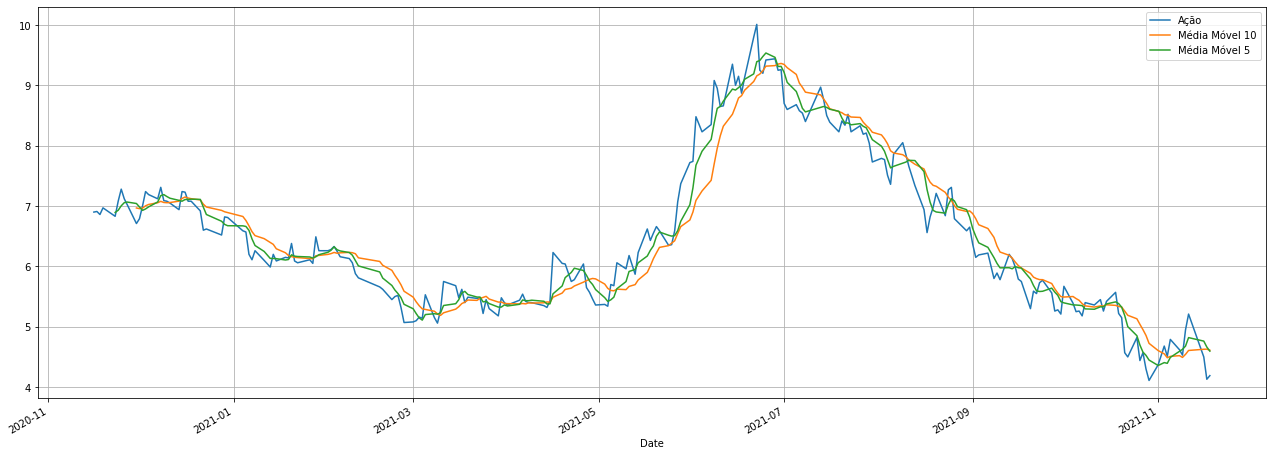

In [29]:
import matplotlib.pyplot as plt
#plotando grafico com amédia móvel
ibov_fatiado = ibov
ibov_fatiado["Close"].plot(figsize=(22,8), label="Ação")
ibov_fatiado["Close"].rolling(10).mean().plot(label="Média Móvel 10")
ibov_fatiado["Close"].rolling(5).mean().plot(label="Média Móvel 5")
plt.grid()
plt.legend();

In [30]:
a = []
a.append(previsa('High'))
a.append(previsa('Low'))
a.append(previsa('Close'))

/home/ricardo/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ricardo/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [31]:
dados = DataFrame(a, columns = [acao,"R²", "EQM"], index = ['Máxima','Mínima','Fechamento'] ).T
dados

,Máxima,Mínima,Fechamento
AMAR3.SA,5.2100,4.1300,5.1500
R²,85.2200,95.6600,80.9800
EQM,0.1546,0.0424,0.1908
